In [ ]:
from google.colab import drive
import os
from PIL import Image, ImageOps
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn as sns

# Mount Google Drive
drive.mount('/content/drive')

# Define the dataset path in Google Drive
data_dir =  '/content/drive/My Drive/totalclasses/'

# Ensure the files exist
assert os.path.exists(data_dir), "Data directory does not exist"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


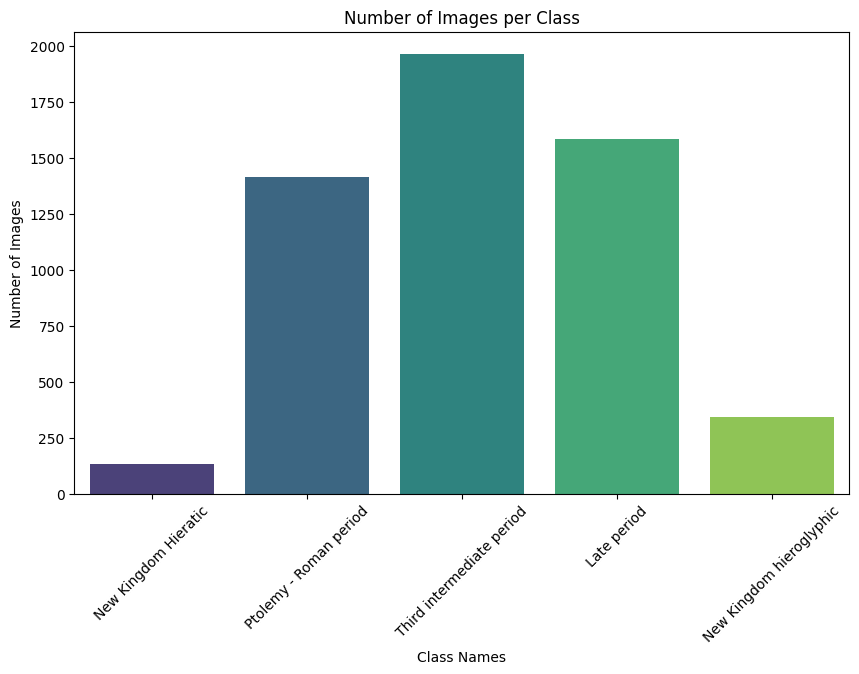

In [ ]:
# Function for Padding and Center Cropping
def preprocess_image(image_path, target_size):
    img = Image.open(image_path)
    img = img.convert("RGB")

    # Calculate ratios for Center Cropping
    img.thumbnail(target_size, Image.LANCZOS)

    delta_width = target_size[0] - img.size[0]
    delta_height = target_size[1] - img.size[1]
    padding = (delta_width // 2, delta_height // 2, delta_width - (delta_width // 2), delta_height - (delta_height // 2))

    new_img = ImageOps.expand(img, padding)
    return new_img

# Test the function on an image
sample_image_path = os.path.join(data_dir, os.listdir(data_dir)[0], os.listdir(os.path.join(data_dir, os.listdir(data_dir)[0]))[0])
processed_image = preprocess_image(sample_image_path, (224, 224))
processed_image.show()


# Get class names and image counts per class
class_names = os.listdir(data_dir)
class_counts = [len(os.listdir(os.path.join(data_dir, class_name))) for class_name in class_names]

# Bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=class_names, y=class_counts, palette="viridis", hue=class_names, dodge=False, legend=False)
plt.xlabel('Class Names')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class')
plt.xticks(rotation=45)
plt.show()


In [ ]:
# ResNet50 model without top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Feature extraction model
feature_extractor = Model(inputs=base_model.input, outputs=x)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Extract features from the dataset
def extract_features(directory, model):
    features = []
    labels = []
    for class_name in class_names:
        class_dir = os.path.join(directory, class_name)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            img = preprocess_image(img_path, (224, 224))
            img_array = np.array(img).reshape((1, 224, 224, 3)) / 255.0
            feature = model.predict(img_array)
            features.append(feature.flatten())
            labels.append(class_name)
    return np.array(features), np.array(labels)

# Extract features
features, labels = extract_features(data_dir, feature_extractor)


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 184ms/step


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 512)               1049088   
                                                                 
 dense_5 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 1051653 (4.01 MB)
Trainable params: 1051653 (4.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
109/109 [==============================] - 2s 17ms/step - loss: 1.3243 - accuracy: 0.4045 - val_loss: 1.1729 - val_accuracy: 0.5126
Epoch 2/10
109/109 [==============================] - 2s 15ms/step - loss: 1.1531 - accuracy: 0.5167 - val_loss: 1.1169 - val_accuracy: 0.5414
Epoch 3/10
109/109 [==============================] - 2s 16ms/step - loss: 1.1148 - accuracy: 0.5219 - val_loss: 1.1169 - val_

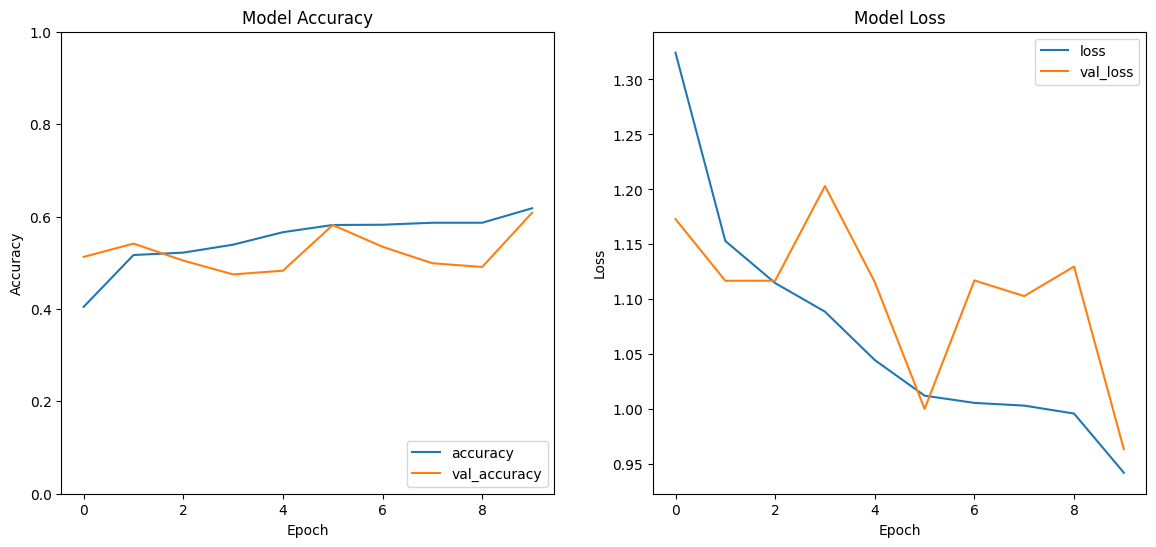

In [ ]:
# Encode the classes
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Split data into training, validation, and test sets
X_temp, X_test, y_temp, y_test = train_test_split(features, encoded_labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

# Build the model
model = Sequential([
    Input(shape=(features.shape[1],)),
    Dense(512, activation='relu'),
    Dense(len(class_names), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Summarize the model
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)

# Print test accuracy
print(f'Test Accuracy: {test_accuracy:.4f}')

# Plot results
plt.figure(figsize=(14, 6))

# Plot model accuracy over epochs
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Model Accuracy')

# Plot model loss over epochs
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Model Loss')

plt.show()


1/1 [==============================] - 0s 57ms/step


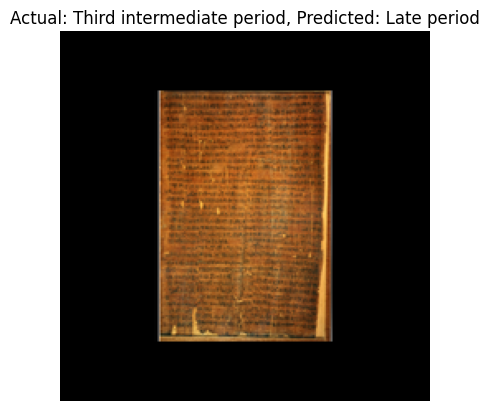

1/1 [==============================] - 0s 25ms/step


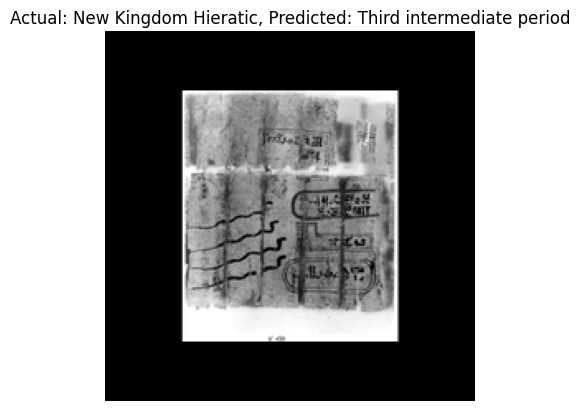

1/1 [==============================] - 0s 20ms/step


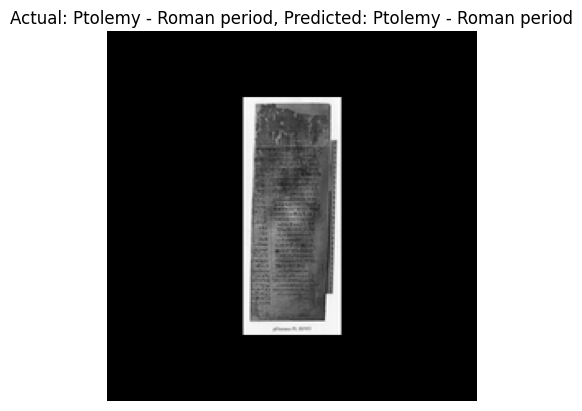

1/1 [==============================] - 0s 27ms/step


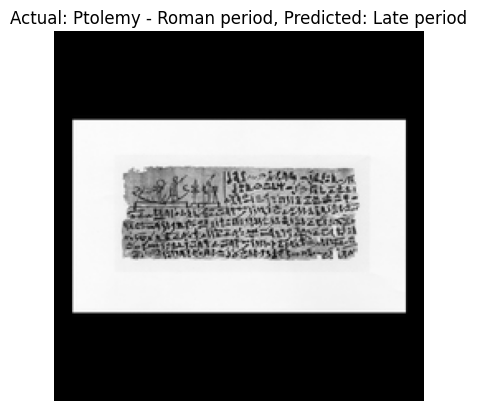

1/1 [==============================] - 0s 21ms/step


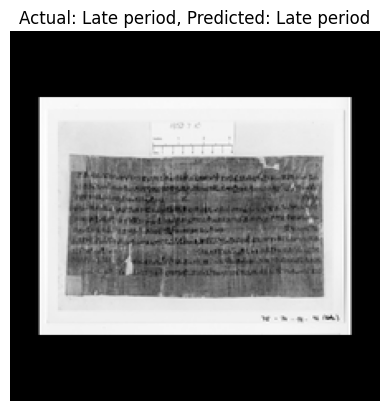

1/1 [==============================] - 0s 21ms/step


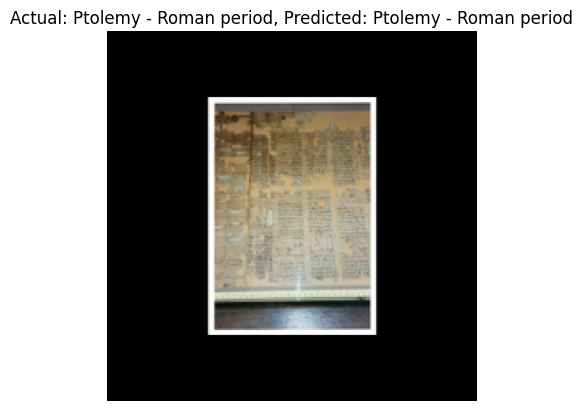

1/1 [==============================] - 0s 21ms/step


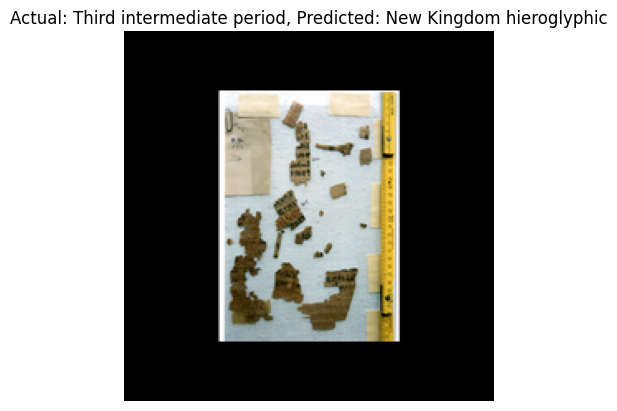

1/1 [==============================] - 0s 31ms/step


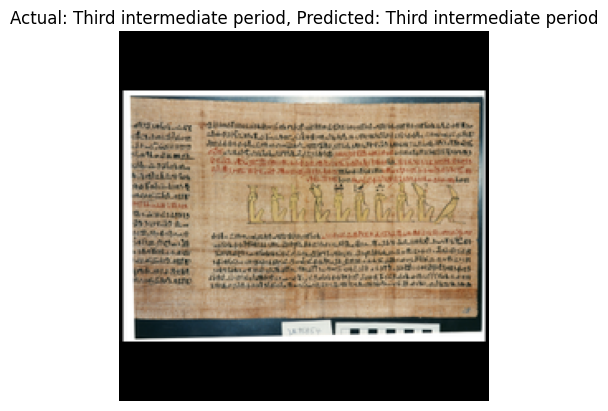

1/1 [==============================] - 0s 26ms/step


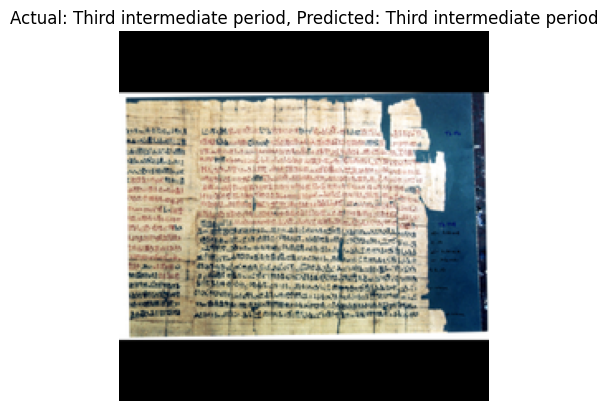

1/1 [==============================] - 0s 23ms/step


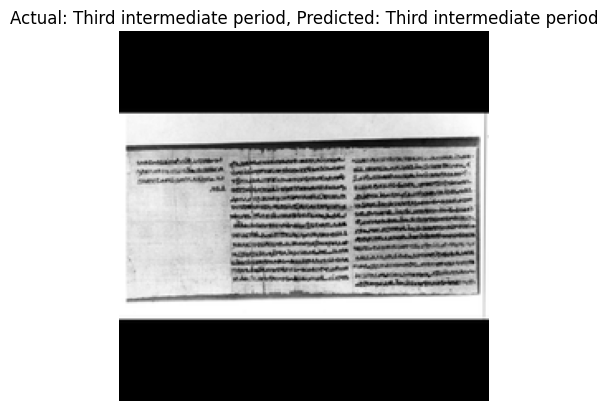

In [ ]:
# Function to predict the class of an image
def predict_and_show(image_path, model, label_encoder):
    img = preprocess_image(image_path, (224, 224))
    img_array = np.array(img).reshape((1, 224, 224, 3)) / 255.0
    feature = feature_extractor.predict(img_array).flatten().reshape(1, -1)
    prediction = model.predict(feature)
    predicted_class = label_encoder.inverse_transform([np.argmax(prediction)])[0]
    actual_class = os.path.basename(os.path.dirname(image_path))

    # Display image with actual and predicted classes
    plt.imshow(img)
    plt.title(f"Actual: {actual_class}, Predicted: {predicted_class}")
    plt.axis('off')
    plt.show()

# Select random images
random_images = random.choices([os.path.join(dp, f) for dp, dn, filenames in os.walk(data_dir) for f in filenames], k=10)

# Display predictions
for image_path in random_images:
    predict_and_show(image_path, model, label_encoder)
